# **NLP Project**

In [1]:
import os
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import sys
sys.path.append("src")
from data_loading import *
from prompt_utils import *
from analysis_utils import *
import re
from tqdm.notebook import tqdm

RESULTS_FOLDER = "results"
os.makedirs(RESULTS_FOLDER, exist_ok=True)

### Dataset downloading

In [2]:
DATASET_PATH = "dataset"

if not os.path.isdir(DATASET_PATH):
    !wget -nc -P . https://allenai.org/data/proofwriter
    !unzip -q -d . proofwriter
    !mv proofwriter-dataset-V2020.12.3 $DATASET_PATH
    !rm proofwriter

### Dataset loading

In [3]:
dataset = ProofWriterDataset(None, DATASET_PATH + "/OWA/depth-3/meta-train.jsonl", triple_label="t", rule_label="r")
examples_dataset = ProofWriterDataset(None, DATASET_PATH + "/OWA/depth-3/meta-dev.jsonl", triple_label="t", rule_label="r")

In [4]:
examples = [examples_dataset[12]] #[(i, e) for i, e in enumerate(examples_dataset) if i < 20]
examples

[{'context': 't1: The bear is kind. t2: The bear is young. t3: The mouse is red. r1: If the mouse likes the bear then the bear likes the mouse. r2: If something likes the bear then the bear visits the mouse. r3: If something is young then it likes the bear. r4: If something is red then it sees the bear. r5: If something visits the mouse then the mouse visits the bear. r6: If something is kind and it visits the bear then the bear is young. ',
  'question': 'The bear visits the mouse.',
  'label': 'True',
  'proof': '((((t2) -> (r3 % int2))) -> (r2 % int1)) ; with int1 = The bear visits the mouse.int2 = The bear likes the bear.'}]

### Model loading

In [5]:
torch.cuda.is_available()

True

In [ ]:
torch.random.manual_seed(0)

model_name = "mistralai/Mistral-7B-Instruct-v0.3"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype="float16",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.float16,
    # torch_dtype="auto",
    trust_remote_code=True,
    attn_implementation="eager"
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = "eos_token_id"

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

### Execution

In [7]:
def str_bool_to_bin(b):
    if b not in ["True", "False"]: raise Exception(f"The input must be True of False; '{b}' received.")
    return int(b == "True")

y_true = []

N_PROMPTS = 1000
prompts = []

for i, e in enumerate(dataset):
    if i >= N_PROMPTS: break
    y_true.append(str_bool_to_bin(e["label"]))
    # print(e["question"])
    # print(e["proof"])
    prompts.append(build_few_shot_prompt(e, examples, proof=True))

prompts[0][0]

'You will be shown a logic theory and a logic question.\nProduce two levels of output:\n  1. Write the final answer (only one word: True or False) inside <final>...</final>.\n  2. Write the proof or reasoning, formatted as in the example, inside <reasoning>...</reasoning>.\n\nProof selection rules:\n- First, check if the conclusion follows directly from a single fact tX.\n- If a single-step proof exists, use ONLY that step.\n- If a single-step proof does NOT exist, use the shortest valid chain.\n- Avoid unnecessary steps or complex derivations. Prefer the shortest chain of rules.\n\nHere is an example.\n\nExample:\nTheory:\nt1: The bear is kind. t2: The bear is young. t3: The mouse is red. r1: If the mouse likes the bear then the bear likes the mouse. r2: If something likes the bear then the bear visits the mouse. r3: If something is young then it likes the bear. r4: If something is red then it sees the bear. r5: If something visits the mouse then the mouse visits the bear. r6: If some

In [8]:
"""tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.eos_token_id
encoded = tokenizer([p[0] for p in prompts], return_offsets_mapping=True, return_tensors="pt", padding=True).to("cuda")
offset_mapping = encoded.pop("offset_mapping")

generation_args = {
    "output_attentions" : True,
    "return_dict_in_generate": True,
    "max_new_tokens": 30,
    "do_sample": False
}

with torch.no_grad():
    outputs = model.generate(**encoded, **generation_args)"""
pass

In [9]:
def text_generation_and_attention_analysis(prompts, y_true, model, tokenizer, experiment_name):

    y_pred = []
    mean_attention_per_group_last_layer = pd.DataFrame(columns=list(prompts[0][1].keys()) + ["correct_prediction"], dtype=np.float64)

    generation_args = {
        "output_attentions" : True,
        "return_dict_in_generate": True,
        "max_new_tokens": 50,
        "do_sample": False,
        "pad_token_id": tokenizer.eos_token_id
    }

    for i, (prompt, prompt_segmentation, theory_segmentation) in tqdm(enumerate(prompts), total=len(prompts)):

        encoded = tokenizer(
            prompt,
            return_offsets_mapping=True,
            return_tensors="pt",
            padding=True
        )

        offset_mapping = encoded.pop("offset_mapping")
        encoded = encoded.to("cuda")

        with torch.no_grad():
            outputs = model.generate(**encoded, **generation_args)


        ###########################
        
        # print(prompt)
        # print("----")
        generated_text = tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)[len(prompt):]
        #print(generated_text)

        tag = "final"
        reg_str = "<" + tag + ">(.*?)</" + tag + ">"
        res = re.findall(reg_str, generated_text)[0]

        y_pred.append(str_bool_to_bin(res))
        correct_prediction = int(y_true[i] == str_bool_to_bin(res))

        input_ids = encoded["input_ids"]
        offsets = offset_mapping[0]
        groups_delimiters_by_characters = reduce(lambda acc, x : acc + [x[1]], prompt_segmentation.values(), [0])
        groups_intervals_by_token = get_groups_delimiter_intervals_by_tokens(groups_delimiters_by_characters, offsets)
        n_input_tokens = groups_intervals_by_token[-1][-1]

        # print([layer[i].detach().to(torch.float32).cpu().numpy() for layer in outputs.attentions])

        prompt_length = encoded["input_ids"].shape[-1]
        new_token_ids = outputs.sequences[0][prompt_length:]
        tokens = tokenizer.convert_ids_to_tokens(new_token_ids)
        non_special_tokens = [t for t in tokens if not tokenizer.special_tokens_map.get(t) and t not in tokenizer.all_special_tokens]
        # print(f"Non special tokens generated: {len(non_special_tokens)}")

        means = []
        
        for k, attn_gen_token in enumerate(outputs.attentions):
            if k == 0: continue # attention map only referred to input tokens
            if k == len(non_special_tokens)+1: break

            means.append(np.mean([head[0][:n_input_tokens] for head in attn_gen_token[-1][0].detach().to(torch.float32).cpu().numpy()], axis=0))

        mean_output_attention = np.mean(means, axis=0)

        groups_mean_attention = np.zeros((1, len(prompt_segmentation)))

        for j, (start, end) in enumerate(groups_intervals_by_token):
            values = mean_output_attention[start:end]
            groups_mean_attention[0][j] = np.mean(values)

        # [l.append(groups_mean_attention[0][j]) for j, l in enumerate(mean_attention_per_group_last_layer)]

        mean_attention_per_group_last_layer = pd.concat([mean_attention_per_group_last_layer, pd.DataFrame([list(groups_mean_attention[0]) + [correct_prediction]], columns= list(prompt_segmentation.keys()) + ["correct_prediction"])], ignore_index=True)

        # 
        theory_intervals_by_token = get_groups_delimiter_intervals_by_tokens(theory_segmentation, offsets)
        mean_attention_on_theory_components = np.zeros((1, len(theory_intervals_by_token)))
        
        for j, (start, end) in enumerate(theory_intervals_by_token):
            values = mean_output_attention[start:end]
            mean_attention_on_theory_components[0][j] = np.mean(values)
        
        
        """plt.figure(figsize=(20, 1))
        hm = sns.heatmap(groups_mean_attention, xticklabels=list(prompt_segmentation.keys()), yticklabels=["output"], cmap="summer", annot=True)
        hm.set_xticklabels(hm.get_xticklabels(), rotation=30, ha="right")
        plt.title("Mean attention from output tokens to input groups of tokens")
        plt.xticks(rotation=30)
        plt.show()

        plt.figure(figsize=(20, 1))
        hm = sns.heatmap(mean_attention_on_theory_components, xticklabels=list([prompt[theory_segmentation[i] : theory_segmentation[i+1]] for i in range(len(theory_segmentation)-1)]), yticklabels=["output"], cmap="summer", annot=True)
        hm.set_xticklabels(hm.get_xticklabels(), rotation=30, ha="right")
        plt.title("Mean attention from output tokens to groups of tokens of the theory")
        plt.show()"""
        
        
        # Deallocate GPU memory

        del outputs, encoded
        torch.cuda.empty_cache()

    compute_performance(y_true, y_pred)

    plt.figure(figsize=(6, 5))

    x_name, y_name = "groups of tokens", "average attention"
    long_df = mean_attention_per_group_last_layer.melt(var_name=x_name, value_name=y_name, id_vars="correct_prediction")

    sns.boxplot(x=x_name, y=y_name, data=long_df, hue="correct_prediction", hue_order=[1, 0], palette=["#1A85FF", "#D41159"], width=.5)

    handles, _ = plt.gca().get_legend_handles_labels()
    plt.legend(handles, ["correct prediction", "incorrect prediction"])
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    os.makedirs(f"{RESULTS_FOLDER}/{experiment_name}", exist_ok=True)
    plt.savefig(f"{RESULTS_FOLDER}/{experiment_name}/average_attentions.png", dpi=400, bbox_inches="tight")
    plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

pos ground truth: 500
neg ground truth: 500 

  accuracy: 0.257
  f1 score: 0.345
      prec: 0.309
       rec: 0.392


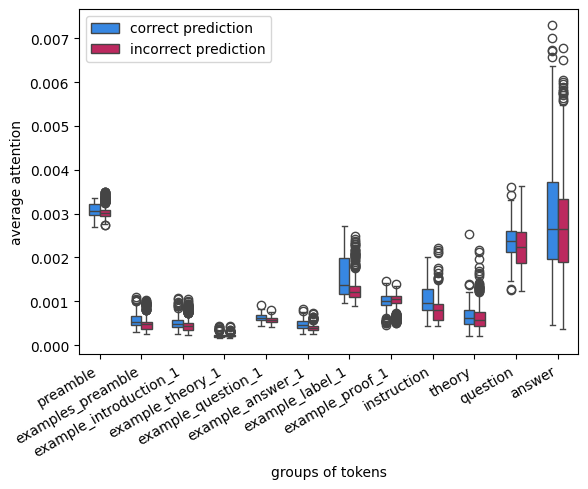

In [10]:
text_generation_and_attention_analysis(prompts, y_true, model, tokenizer, "one_shot")